In [ ]:
#!pip install bertopic sentence-transformers umap-learn hdbscan gensim


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 5.9 MB/s  0:00:00 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 2.1 MB/s  0:00:11 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.2/37.2 MB 3.4 MB/s  0:00:10m0:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 4.4 MB/s  0:00:00m0:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10/10 [bertopic]/10 [bertopic]transformers]


In [22]:
import os, re, glob, json
import numpy as np
import pandas as pd
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
from gensim.corpora import Dictionary
from gensim.models.coherencemodel import CoherenceModel



In [105]:

DATA_DIRS = ["2013", "2014", "2015"]   # or one folder if you prefer
OUT_DIR = "outputs"
os.makedirs(OUT_DIR, exist_ok=True)

### Define EU list

In [106]:
EU_COUNTRIES = {
    "Austria","Belgium","Bulgaria","Croatia","Cyprus","Czech Republic","Denmark",
    "Estonia","Finland","France","Germany","Greece","Hungary","Ireland","Italy",
    "Latvia","Lithuania","Luxembourg","Malta","Netherlands","Poland","Portugal",
    "Romania","Spain","Sweden"
}


### Collect file paths

In [108]:
paths = []
for d in DATA_DIRS:
    paths.extend(glob.glob(os.path.join(d, "*.txt")))
paths = sorted(paths)

len(paths), paths[:3]


(585, ['2013/Afghanistan.txt', '2013/Albania.txt', '2013/Algeria.txt'])

### Cleaning + section split + chunking

In [109]:
SCRIPT_STYLE_RE = re.compile(r"<(script|style)[^>]*>.*?</\1>", re.IGNORECASE | re.DOTALL)
TAG_RE = re.compile(r"<[^>]+>")
WS_RE = re.compile(r"\s+")

def strip_html(html: str) -> str:
    html = SCRIPT_STYLE_RE.sub(" ", html)
    text = TAG_RE.sub(" ", html)
    text = (text.replace("&amp;", "&")
                .replace("&nbsp;", " ")
                .replace("&quot;", '"')
                .replace("&lt;", "<")
                .replace("&gt;", ">"))
    return WS_RE.sub(" ", text).strip()

def detect_sections(text: str):
    headings = [
        "EXECUTIVE SUMMARY", "EXECUTIVE SUMMARY:",
        "Section 1.", "SECTION 1.", "Section 1:", "SECTION 1:",
        "Section 2.", "SECTION 2.", "Section 2:", "SECTION 2:",
        "Section 3.", "SECTION 3.", "Section 3:", "SECTION 3:",
        "Section 4.", "SECTION 4.", "Section 4:", "SECTION 4:",
        "Section 5.", "SECTION 5.", "Section 5:", "SECTION 5:",
        "Section 6.", "SECTION 6.", "Section 6:", "SECTION 6:",
        "Section 7.", "SECTION 7.", "Section 7:", "SECTION 7:",
    ]
    pattern = "(" + "|".join(re.escape(h) for h in headings) + ")"
    parts = re.split(pattern, text)

    if len(parts) <= 1:
        return [("FULL_TEXT", text)]

    sections = []
    pre = parts[0].strip()
    if pre:
        sections.append(("PREAMBLE", pre))

    i = 1
    while i < len(parts) - 1:
        title = parts[i].strip()
        body = parts[i+1].strip()
        if body:
            sections.append((title, body))
        i += 2
    return sections

def split_into_word_chunks(text: str, min_words=120, max_words=250):
    words = text.split()
    chunks = []
    i = 0
    while i < len(words):
        j = min(i + max_words, len(words))
        chunk = words[i:j]
        if len(chunk) >= min_words:
            chunks.append(" ".join(chunk))
        i = j
    return chunks


### Build the full dataset table (ALL countries)

In [110]:
rows = []
for p in paths:
    with open(p, "r", encoding="utf-8", errors="replace") as f:
        year = f.readline().strip()
        country = f.readline().strip()
        html = f.read()

    plain = strip_html(html)
    for sec_title, sec_text in detect_sections(plain):
        for k, ch in enumerate(split_into_word_chunks(sec_text, 120, 250)):
            rows.append({
                "year": year,
                "country": country,
                "is_eu": country in EU_COUNTRIES,
                "section": sec_title,
                "source_file": os.path.basename(p),
                "chunk_id": f"{os.path.basename(p)}::{sec_title}::{k}",
                "text": ch
            })

df = pd.DataFrame(rows)
df.shape, df.head()


((26785, 7),
    year      country  is_eu            section      source_file  \
 0  2013  Afghanistan  False  EXECUTIVE SUMMARY  Afghanistan.txt   
 1  2013  Afghanistan  False         Section 1.  Afghanistan.txt   
 2  2013  Afghanistan  False         Section 1.  Afghanistan.txt   
 3  2013  Afghanistan  False         Section 1.  Afghanistan.txt   
 4  2013  Afghanistan  False         Section 1.  Afghanistan.txt   
 
                                 chunk_id  \
 0  Afghanistan.txt::EXECUTIVE SUMMARY::0   
 1         Afghanistan.txt::Section 1.::0   
 2         Afghanistan.txt::Section 1.::1   
 3         Afghanistan.txt::Section 1.::2   
 4         Afghanistan.txt::Section 1.::3   
 
                                                 text  
 0  Share Afghanistan is an Islamic republic with ...  
 1  Respect for the Integrity of the Person, Inclu...  
 2  judges, prosecutors, and clerical staff. In Ju...  
 3  were reports that insurgent groups were respon...  
 4  with fists and electr

### Verify counts (world vs EU)

In [111]:
df.groupby(["year"])["country"].nunique(), df["is_eu"].mean()


(year
 2013    195
 2014    195
 2015    195
 Name: country, dtype: int64,
 np.float64(0.10293074481986186))

In [112]:
# How many EU chunks?
df[df["is_eu"]].groupby("year")["country"].nunique()


year
2013    25
2014    25
2015    25
Name: country, dtype: int64

### Fit BERTopic on the full corpus

In [113]:


docs_all = df["text"].tolist()

embedder = SentenceTransformer("all-MiniLM-L6-v2")

topic_model = BERTopic(
    embedding_model=embedder,
    calculate_probabilities=False,
    verbose=True
)

topics, _ = topic_model.fit_transform(docs_all)
df["topic"] = topics

topic_info = topic_model.get_topic_info()
topic_info.head(10)


2026-01-01 19:01:39,524 - BERTopic - Embedding - Transforming documents to embeddings.
Batches: 100%|██████████| 838/838 [05:57<00:00,  2.34it/s]
2026-01-01 19:07:38,915 - BERTopic - Embedding - Completed ✓
2026-01-01 19:07:38,918 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2026-01-01 19:07:45,373 - BERTopic - Dimensionality - Completed ✓
2026-01-01 19:07:45,379 - BERTopic - Cluster - Start clustering the reduced embeddings
2026-01-01 19:07:49,056 - BERTopic - Cluster - Completed ✓
2026-01-01 19:07:49,081 - BERTopic - Representation - Fine-tuning topics using representation models.
2026-01-01 19:07:52,115 - BERTopic - Representation - Completed ✓


,Topic,Count,Name,Representation,Representative_Docs
0,-1,6702,-1_the_of_and_to,"[the, of, and, to, in, on, government, for, th...","[forces generally acted with impunity, the Min..."
1,0,4241,0_labor_workers_work_union,"[labor, workers, work, union, unions, employer...",[Worker Rights Share a. Freedom of Association...
2,1,2909,1_children_child_women_marriage,"[children, child, women, marriage, age, birth,...","[law, property law, and in the judicial system..."
3,2,1263,2_corruption_officials_public_disclosure,"[corruption, officials, public, disclosure, in...",[Corruption and Lack of Transparency in Govern...
4,3,624,3_rape_violence_domestic_spousal,"[rape, violence, domestic, spousal, women, dis...","[Discrimination, Societal Abuses, and Traffick..."
5,4,574,4_prisoners_prison_prisons_inmates,"[prisoners, prison, prisons, inmates, conditio...",[assaulting detainees or being complicit in pu...
6,5,533,5_arrest_detainees_bail_detention,"[arrest, detainees, bail, detention, police, h...","[According to media, a police investigation co..."
7,6,388,6_police_security_arrest_forces,"[police, security, arrest, forces, responsible...","[had reasonable access to visitors, could atte..."
8,7,374,7_elections_participation_women_minorities,"[elections, participation, women, minorities, ...",[Respect for Political Rights: The Right of Ci...
9,8,368,8_prisoners_prison_prisons_monitoring,"[prisoners, prison, prisons, monitoring, compl...",[since the prison administration did not maint...


In [61]:
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,7490,-1_the_of_and_to,"[the, of, and, to, in, government, for, on, th...","[Respect for the Integrity of the Person, Incl..."
1,0,4240,0_labor_workers_work_union,"[labor, workers, work, union, unions, employer...",[and trade union officials in identifying forc...
2,1,1271,1_corruption_officials_public_disclosure,"[corruption, officials, public, disclosure, in...",[Corruption and Lack of Transparency in Govern...
3,2,734,2_hiv_lgbt_aids_lgbti,"[hiv, lgbt, aids, lgbti, discrimination, orien...",[public schools provided special education cla...
4,3,618,3_prisoners_prison_prisons_inmates,"[prisoners, prison, prisons, inmates, conditio...","[Respect for the Integrity of the Person, Incl..."
...,...,...,...,...,...
183,182,10,182_nuer_spla_jonglei_dinka,"[nuer, spla, jonglei, dinka, pg, civilians, mu...",[gathered on the basis of their ethnicity in t...
184,183,10,183_birth_reproductive_abuse_child,"[birth, reproductive, abuse, child, citizenshi...","[Interior, and the Ministry of Justice. Sexual..."
185,184,10,184_arab_students_jnf_education,"[arab, students, jnf, education, schools, jewi...","[school in the city, although 20 percent of re..."
186,185,10,185_diecp_ipid_saps_officers,"[diecp, ipid, saps, officers, police, cases, f...",[power at the end of each 90-day period follow...


>The model produced a large number of topics (188 including outliers). Topic sizes are highly imbalanced: a few topics are very large (e.g., labor rights), while many topics are small (around 10 chunks). For reporting and interpretation, we focus on the most frequent topics and treat small topics as niche/country-specific.

### Coherence + diversity 188 topic

In [ ]:
from gensim.corpora import Dictionary
from gensim.models.coherencemodel import CoherenceModel

def topic_diversity(topic_words, topk=10):
    all_words = []
    for wlist in topic_words:
        all_words.extend(wlist[:topk])
    return len(set(all_words)) / max(1, len(all_words))

def coherence_cv(tokenized_docs, topic_words):
    dictionary = Dictionary(tokenized_docs)
    corpus = [dictionary.doc2bow(toks) for toks in tokenized_docs]
    cm = CoherenceModel(
        topics=topic_words,
        texts=tokenized_docs,
        corpus=corpus,
        dictionary=dictionary,
        coherence="c_v"
    )
    return float(cm.get_coherence())

topic_words = [get_topic_words(topic_model, tid, 20) for tid in valid_topic_ids]
tokenized = [d.split() for d in docs_all]

metrics = {
    "coherence_c_v": coherence_cv(tokenized, topic_words),
    "topic_diversity_top10": topic_diversity(topic_words, topk=10),
    "n_topics_excluding_outliers": len(valid_topic_ids)
}
metrics


This topic-size pattern often happens because:
the dataset is diverse (many countries, many issues),
chunking creates many small “mini-documents”,
HDBSCAN clustering prefers to split rare patterns into separate small clusters.


### Reducing Topics to the “main topics”

In [73]:
topic_info = topic_model.get_topic_info().copy()

# Exclude outliers for interpretation
main_topics = topic_info[topic_info["Topic"] != -1].copy()

# Add share
main_topics["share"] = main_topics["Count"] / main_topics["Count"].sum()

main_topics.head(30)[["Topic","Count","share","Name"]]


,Topic,Count,share,Name
1,0,4240,0.219746,0_labor_workers_the_and
2,1,2417,0.125266,1_prisoners_to_the_prison
3,2,1807,0.093651,2_corruption_the_and_of
4,3,1387,0.071884,3_the_in_of_and
5,4,1172,0.060741,4_rape_violence_domestic_women
6,5,1114,0.057735,5_freedom_the_and_of
7,6,997,0.051671,6_women_children_birth_to
8,7,905,0.046903,7_refugees_asylum_the_to
9,8,823,0.042654,8_elections_political_the_parties
10,9,750,0.038870,9_hiv_lgbt_discrimination_aids


### Merge/limit topics
BERTopic has a built-in way to reduce the number of topics:

In [68]:
# Reduce topics to a more interpretable number (e.g., 30)
topic_model_reduced = topic_model.reduce_topics(df["text"].tolist(), nr_topics=30)


2026-01-01 17:40:15,204 - BERTopic - Topic reduction - Reducing number of topics
2026-01-01 17:40:15,259 - BERTopic - Representation - Fine-tuning topics using representation models.
2026-01-01 17:40:17,999 - BERTopic - Representation - Completed ✓
2026-01-01 17:40:18,005 - BERTopic - Topic reduction - Reduced number of topics from 188 to 30


>To improve interpretability, we reduced the number of topics from 188 to 30 using BERTopic topic reduction. This merges small similar clusters into broader themes, making the results easier to summarize while preserving the main patterns.”

### topic size distribution

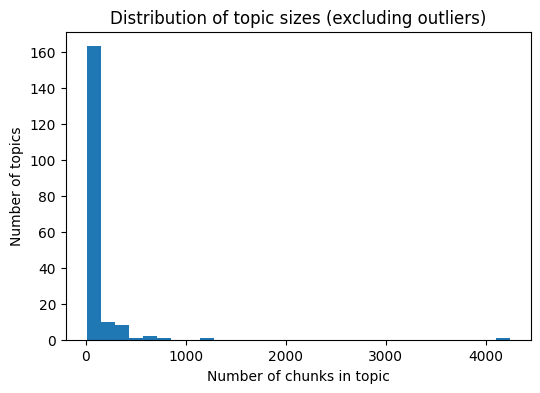

In [69]:
import matplotlib.pyplot as plt

sizes = main_topics["Count"].values

plt.figure(figsize=(6,4))
plt.hist(sizes, bins=30)
plt.title("Distribution of topic sizes (excluding outliers)")
plt.xlabel("Number of chunks in topic")
plt.ylabel("Number of topics")
plt.show()


The topic size distribution is highly imbalanced: a small number of topics cover a large part of the corpus, while most topics are small. This suggests the dataset contains both global recurring themes and many niche country-specific issues.”

### Quantify outlier percentage

In [70]:
total = topic_info["Count"].sum()
outliers = int(topic_info.loc[topic_info["Topic"] == -1, "Count"].iloc[0])
outlier_rate = outliers / total
outlier_rate


np.float64(0.2796341235766287)

> Approximately 28% of chunks were classified as outliers (-1) and were excluded from topic comparisons.”

### Helper to view topic words

In [38]:
def get_topic_words(model, topic_id, topn=10):
    pairs = model.get_topic(topic_id) or []
    return [w for w, _ in pairs[:topn]]

valid_topic_ids = [t for t in topic_model.get_topics().keys() if t != -1]
for tid in valid_topic_ids[:8]:
    print(tid, get_topic_words(topic_model, tid, 10))



0 ['labor', 'workers', 'work', 'union', 'unions', 'employers', 'minimum', 'sector', 'employment', 'forced']
1 ['corruption', 'officials', 'public', 'disclosure', 'information', 'financial', 'transparency', 'assets', 'corrupt', 'anticorruption']
2 ['hiv', 'lgbt', 'aids', 'lgbti', 'discrimination', 'orientation', 'transgender', 'identity', 'stigma', 'gay']
3 ['prisoners', 'prison', 'prisons', 'inmates', 'conditions', 'facilities', 'held', 'overcrowding', 'detention', 'detainees']
4 ['rape', 'violence', 'domestic', 'spousal', 'women', 'discrimination', 'gender', 'race', 'societal', 'sexual']
5 ['arrest', 'detainees', 'bail', 'detention', 'hours', 'police', 'suspects', 'authorities', 'suspect', 'detainee']
6 ['elections', 'participation', 'women', 'minorities', 'political', 'seats', 'cabinet', 'parties', 'parliament', 'seat']
7 ['prisoners', 'prison', 'prisons', 'monitoring', 'complaints', 'visits', 'permitted', 'detention', 'conditions', 'independent']


## Evaluation reduced topics
### Coherence + diversity

Coherence measures if top words inside a topic match one theme. Higher coherence means topics are easier to understand. (Are the topic words connected and meaningful together?)
- Higher coherence value = usually better


Topic diversity shows how many unique words appear in top words of topics. Higher diversity means topics are not copies. (Are topics different from each other, or are they repeating the same words?)
- Higher diversity = less repetition.

In [74]:
from gensim.corpora import Dictionary
from gensim.models.coherencemodel import CoherenceModel

def get_topic_words_safe(model, topic_id, topn=20):
    pairs = model.get_topic(topic_id)
    if not pairs:
        return []
    return [w for (w, _) in pairs[:topn] if isinstance(w, str) and w.strip()]

def build_valid_topic_words(model, topn=20, min_words=5):
    topic_words = []
    topic_ids = []
    for tid in model.get_topics().keys():
        if tid == -1:
            continue
        words = get_topic_words_safe(model, tid, topn=topn)
        # keep only topics that have enough usable words
        if len(words) >= min_words:
            topic_words.append(words)
            topic_ids.append(tid)
    return topic_ids, topic_words

def topic_diversity(topic_words, topk=10):
    all_words = []
    for wlist in topic_words:
        all_words.extend(wlist[:topk])
    return len(set(all_words)) / max(1, len(all_words))

def coherence_cv(tokenized_docs, topic_words):
    dictionary = Dictionary(tokenized_docs)
    corpus = [dictionary.doc2bow(toks) for toks in tokenized_docs]
    cm = CoherenceModel(
        topics=topic_words,
        texts=tokenized_docs,
        corpus=corpus,
        dictionary=dictionary,
        coherence="c_v"
    )
    return float(cm.get_coherence())

# IMPORTANT: rebuild topics from the (reduced) model
topic_ids_eval, topic_words_eval = build_valid_topic_words(topic_model, topn=20, min_words=5)

tokenized = [d.split() for d in docs_all]

metrics = {
    "coherence_c_v": coherence_cv(tokenized, topic_words_eval),
    "topic_diversity_top10": topic_diversity(topic_words_eval, topk=10),
    "n_topics_excluding_outliers": len(topic_ids_eval),
    "skipped_topics_due_to_empty_words": (len([t for t in topic_model.get_topics().keys() if t != -1]) - len(topic_ids_eval))
}
metrics


{'coherence_c_v': 0.47323458226538656,
 'topic_diversity_top10': 0.5586206896551724,
 'n_topics_excluding_outliers': 29,
 'skipped_topics_due_to_empty_words': 0}

>We first trained BERTopic and obtained 188 topics (excluding outliers). This produced more fine-grained themes and higher quantitative topic quality metrics. However, many topics were very small and difficult to interpret. Therefore, we reduced the model to 30 topics to improve interpretability. After reduction, coherence (c_v = 0.473) and topic diversity (0.559) decreased, which is expected because reduced topics are broader and share more general vocabulary. We use the reduced model for reporting and comparisons, while the full model supports detailed exploration.

### Stability 

Simple meaning: If we rerun the model, do we get similar topics? 
Higher overlap = more stable.



In [77]:
def jaccard(a, b):
    a, b = set(a), set(b)
    return len(a & b) / max(1, len(a | b))

def run_model_with_seed(seed: int):
    np.random.seed(seed)
    idx = np.random.permutation(len(docs_all))
    docs_shuffled = [docs_all[i] for i in idx]
    tm = BERTopic(embedding_model=embedder, verbose=False)
    tm.fit_transform(docs_shuffled)
    valid = [tid for tid in tm.get_topics().keys() if tid != -1]
    return {tid: get_topic_words(tm, tid, 15) for tid in valid}

w1 = run_model_with_seed(1)
w2 = run_model_with_seed(2)

scores = []
for t1, words1 in list(w1.items())[:15]:
    best = 0.0
    for t2, words2 in w2.items():
        best = max(best, jaccard(words1, words2))
    scores.append(best)

{"stability_mean_best_jaccard": float(np.mean(scores)),
 "stability_median_best_jaccard": float(np.median(scores))}


{'stability_mean_best_jaccard': 0.8707070707070707,
 'stability_median_best_jaccard': 0.8181818181818182}

We tested stability by fitting the model twice with different shuffle. The overlap was 0.81 . This shows the topics are stable.

## EU-focused interpretation 
### Topic share inside EU vs non-EU

Positive delta: topic is more common in EU
Negative delta: topic is more common in non-EU

We compared topic shares between EU and non-EU reports. Some topics appear more in EU (delta positive), others more in non-EU (delta negative).”

In [79]:
docs_all = df["text"].tolist()

# After reduce_topics, re-transform to get the updated topic assignments
topics_new, _ = topic_model.transform(docs_all)

df["topic_reduced"] = topics_new


Batches: 100%|██████████| 838/838 [05:59<00:00,  2.33it/s]


In [86]:


def topic_share(subdf: pd.DataFrame, label: str, topic_col="topic_reduced"):
    t = (subdf[subdf[topic_col] != -1]
         .groupby(topic_col).size().reset_index(name="n"))
    t["share"] = t["n"] / t["n"].sum()
    t["group"] = label
    return t.rename(columns={topic_col: "topic"})

eu = topic_share(df[df["is_eu"]], "EU", topic_col="topic_reduced")
non_eu = topic_share(df[~df["is_eu"]], "Non-EU", topic_col="topic_reduced")

compare = pd.concat([eu, non_eu], ignore_index=True)
compare = compare.pivot_table(index="topic", columns="group", values="share", fill_value=0.0).reset_index()
compare["delta_EU_minus_NonEU"] = compare.get("EU", 0.0) - compare.get("Non-EU", 0.0)



### removing stopwords from topic words

>Because our main model uses transformer embeddings, we avoided heavy stopword removal before embedding to preserve contextual meaning. Instead, we applied stopword filtering at the topic representation stage to improve interpretability of topic keywords.”

In [88]:
STOP = set("""
the of and to in for on with as at by from is are was were be been being this that it its
a an or not have has had may can will would should could
""".split())

def get_topic_words_clean(model, topic_id, topn=10):
    pairs = model.get_topic(topic_id) or []
    words = [w for (w, _) in pairs if isinstance(w, str)]
    words = [w for w in words if w.lower() not in STOP and len(w) > 2]
    return words[:topn]

compare["top_words"] = compare["topic"].apply(lambda t: ", ".join(get_topic_words_clean(topic_model, int(t), 10)))
compare.sort_values("delta_EU_minus_NonEU", ascending=False).head(15)


group,topic,EU,Non-EU,delta_EU_minus_NonEU,top_words
15,15,0.068137,0.006955,0.061183,"roma, romani, ethnic, education"
16,16,0.049510,0.004694,0.044816,"anti, jewish, semitic, holocaust, semitism"
7,7,0.070098,0.044161,0.025937,"refugees, asylum, seekers, refugee, unhcr, pro..."
1,1,0.135294,0.124080,0.011214,"prisoners, prison, detention, detainees, autho..."
14,14,0.025490,0.015416,0.010074,"problems, human, security, rights, forces, abu..."
17,17,0.014706,0.007360,0.007346,"citizenship, stateless, persons, country, bido..."
23,23,0.006373,0.000000,0.006373,"constitutional, court, obh, retirement, justic..."
10,10,0.038235,0.032338,0.005897,"disabilities, persons, mental, education"
2,2,0.097549,0.093190,0.004359,"corruption, public, officials, government, police"
4,4,0.062255,0.060562,0.001693,"rape, violence, domestic, women, sexual, victims"


>EU reports show strong emphasis on minority integration (Roma/Romani), anti-Semitism, and asylum/refugee protection. Many other themes such as prisons, corruption, and violence against women are global topics and appear in both EU and non-EU reports at similar rates. This confirms that the topic model identifies both region-specific and universal human-rights themes.

### stopword-aware topic words helper

In [ ]:
import re

#  stopword list (English + report boilerplate)
STOP = set("""
a an and are as at be been being by can could did do does doing for from had has have having
he her hers herself him himself his how i if in into is it its itself just me more most my
myself no nor not of on once only or other our ours ourselves out over own same she should
so some such than that the their theirs them themselves then there these they this those
through to too under until up very was we were what when where which while who whom why will with would you your yours yourself yourselves

section executive summary share government law provides including respect rights person persons
""".split())

def clean_tokens(words):
    """Keep only meaningful tokens: letters only, not stopwords, length>=3."""
    out = []
    for w in words:
        w = w.lower().strip()
        w = re.sub(r"[^a-z]+", "", w)      # remove punctuation/numbers
        if not w:
            continue
        if w in STOP:
            continue
        if len(w) < 3:
            continue
        out.append(w)
    return out

def get_topic_words_clean(model, topic_id, topn=10):
    """
    Return topn clean words for a topic. Uses BERTopic get_topic().
    """
    pairs = model.get_topic(int(topic_id)) or []
    raw = [w for (w, _) in pairs]
    cleaned = clean_tokens(raw)
    return cleaned[:topn]

def topic_words_str(model, topic_id, topn=10):
    """Convenience: returns a comma-separated string of clean topic words."""
    return ", ".join(get_topic_words_clean(model, topic_id, topn=topn))


### Topics more common in non-EU

In [95]:
# Topics more common in non-EU (most negative delta)
compare["top_words"] = compare["topic"].apply(lambda t: topic_words_str(topic_model, t, 8))
compare.sort_values("delta_EU_minus_NonEU", ascending=True).head(15)

group,topic,EU,Non-EU,delta_EU_minus_NonEU,top_words
3,3,0.022549,0.077717,-0.055168,"police, torture"
0,0,0.196078,0.222544,-0.026466,"labor, workers, work"
13,13,0.000490,0.026717,-0.026227,"forces, killed, civilians, armed"
6,6,0.032843,0.053897,-0.021054,"women, children, birth, percent, child"
5,5,0.044608,0.059287,-0.014679,"freedom, internet, media, press"
8,8,0.030882,0.044045,-0.013163,"elections, political, parties, election, parti..."
18,18,0.000000,0.007824,-0.007824,"idps, displaced, displacement, idp"
20,20,0.000000,0.006897,-0.006897,"indigenous, land, lands, communities, afro"
11,11,0.030392,0.033150,-0.002758,"child, children, age, marriage, years, sexual"
21,21,0.000000,0.000985,-0.000985,"dalit, dalits, caste, manual, upper, scavenger..."


>The comparison shows clear regional differences. EU reports emphasize minority discrimination topics (e.g., Roma, anti-Semitism, asylum systems—shown in the EU-heavy table), while non-EU reports emphasize more severe security and conflict themes such as torture, armed conflict, internal displacement, and indigenous land issues. At the same time, some topics like labor rights appear frequently in both groups, showing shared global human-rights categories.

### Filter for preventing over interpret
We focus on topics with sufficient frequency (≥1% share) to avoid noise

In [96]:
compare2 = compare.copy()
compare2["abs_delta"] = compare2["delta_EU_minus_NonEU"].abs()
compare2 = compare2.sort_values("abs_delta", ascending=False)

# keep only topics where either group share is at least 1%
strong = compare2[(compare2["EU"] >= 0.01) | (compare2["Non-EU"] >= 0.01)]
strong.head(20)


group,topic,EU,Non-EU,delta_EU_minus_NonEU,top_words,abs_delta
15,15,0.068137,0.006955,0.061183,"roma, romani, ethnic, education",0.061183
3,3,0.022549,0.077717,-0.055168,"police, torture",0.055168
16,16,0.049510,0.004694,0.044816,"anti, jewish, semitic, holocaust, semitism",0.044816
0,0,0.196078,0.222544,-0.026466,"labor, workers, work",0.026466
13,13,0.000490,0.026717,-0.026227,"forces, killed, civilians, armed",0.026227
7,7,0.070098,0.044161,0.025937,"refugees, asylum, seekers, refugee, unhcr, pro...",0.025937
6,6,0.032843,0.053897,-0.021054,"women, children, birth, percent, child",0.021054
5,5,0.044608,0.059287,-0.014679,"freedom, internet, media, press",0.014679
8,8,0.030882,0.044045,-0.013163,"elections, political, parties, election, parti...",0.013163
1,1,0.135294,0.124080,0.011214,"prisoners, prison, detention, detainees, autho...",0.011214


>We compared topic frequency between EU and non-EU reports using normalized shares within each group. We then ranked topics by the absolute difference (abs_delta) and kept only topics with at least 1% share in either group to avoid noise. The results show clear regional patterns. EU reports contain more topics about Roma minority integration, asylum procedures, anti-Semitism, and European legal institutions such as the ECHR and ombudsman systems. Non-EU reports contain more content about labor rights, elections, protest restrictions, and conflict-related themes. These differences support that the model captures meaningful regional variation.”

### Representative chunks per topic

In [102]:
def representative_chunks(df, topic_id, n=3):
    sub = df[df["topic"] == topic_id].copy()
    if len(sub) == 0:
        return []
    # choose longer chunks so they contain more meaning
    sub["n_words"] = sub["text"].str.split().str.len()
    sub = sub.sort_values("n_words", ascending=False).head(20)
    return sub.sample(min(n, len(sub)), random_state=42)[["year","country","section","text"]].to_dict("records")

for tid in valid_topic_ids[:10]:
    print("\n", tid, topic_name(tid), topic_words_str(topic_model, tid, 10))
    reps = representative_chunks(df, tid, n=2)
    for r in reps:
        print(" -", r["country"], r["year"], r["section"], ":", r["text"][:200], "...")



 0 Topic 0 labor, workers, work
 - Afghanistan 2013 Section 7. : Worker Rights Share a. Freedom of Association and the Right to Collective Bargaining The law provides for the right of workers to join and form independent unions and to conduct legal strikes and barg ...
 - Tunisia 2014 Section 7. : Worker Rights Share a. Freedom of Association and the Right to Collective Bargaining The law provides workers with the right to organize, form and join unions, and bargain collectively. The law allows ...

 1 Topic 1 prisoners, prison, detention, detainees, authorities
 - Afghanistan 2013 Section 4. : Corruption and Lack of Transparency in Government Share The law provides criminal penalties for official corruption. The government did not implement the law effectively, and there were reports that o ...
 - Portugal 2014 Section 4. : Corruption and Lack of Transparency in Government Share The law provides criminal penalties for corruption by officials, and the government generally implemented 

1. Topic validity / interpretability:
- The top words match the example texts.
2. Cross-country consistency:
- Same topics appear in many countries → topics are not random.
3. Section alignment:

- Many topics match the report structure (e.g., Worker Rights = Section 7, Corruption = Section 4).
This is a strong sign the model is working correctly.

4. Topic granularity:

- Model separates related topics (Topic 3 vs Topic 7: prison conditions vs monitoring).

### clear topic names automatically

In [97]:
topic_labels = {}
for tid in valid_topic_ids[:30]:

    words = get_topic_words_clean(topic_model, tid, 5)
    topic_labels[tid] = " / ".join(words[:2]) if len(words) >= 2 else f"Topic {tid}"
df["topic_label_auto"] = df["topic"].map(topic_labels).fillna("outlier")




### Add “topic → top section”

In [103]:
top_section = (df[df["topic"] != -1]
               .groupby(["topic","section"]).size()
               .reset_index(name="n"))
top_section["share"] = top_section["n"] / top_section.groupby("topic")["n"].transform("sum")
top_section = top_section.sort_values(["topic","share"], ascending=[True, False]).groupby("topic").head(1)

top_section["top_words"] = top_section["topic"].apply(lambda t: topic_words_str(topic_model, t, 8))
top_section.head(20)


,topic,section,n,share,top_words
2,0,Section 7.,4220,0.995283,"labor, workers, work"
7,1,Section 4.,1241,0.976397,"prisoners, prison, detention, detainees, autho..."
10,2,Section 6.,717,0.976839,"corruption, public, officials, police"
13,3,Section 1.,615,0.995146,"police, torture"
16,4,Section 6.,598,0.996667,"rape, violence, domestic, women, sexual, victims"
18,5,Section 1.,496,0.992000,"freedom, internet, media, press"
19,6,Section 3.,376,0.989474,"women, children, birth, percent, child"
22,7,Section 1.,372,0.986737,"refugees, asylum, seekers, refugee, unhcr, pro..."
25,8,Section 6.,350,0.983146,"elections, political, parties, election, parti..."
29,9,Section 6.,342,0.988439,"hiv, lgbt, discrimination, aids, lgbti, orient..."


>To validate topic quality, we examined how topics align with the report structure. For each topic, we identified the section that contains the largest share of its chunks. Most topics show very high concentration (often above 95%) in a single section (e.g., labor rights in Section 7, gender-based violence in Section 6, torture in Section 1). This strong alignment indicates that the topic model captures meaningful themes rather than random word clusters. One topic (security forces abuses) is broader and less concentrated, which is expected for complex themes spanning multiple rights areas.

### Clean Tokens
We preserved full text for transformer embeddings to keep context, but removed stopwords when presenting topic keywords and when computing coherence metrics to improve interpretability.

In [ ]:
# def tokenize_for_coherence(text):
#     return [w for w in re.findall(r"[a-z]+", text.lower()) if w not in STOP and len(w) >= 3]

# tokenized = [tokenize_for_coherence(d) for d in docs_all]


### Topic-by-year comparison for EU and World
اینجارو ران کن

In [104]:
def topic_share_by_year(subdf, label):
    t = (subdf[subdf["topic"] != -1]
         .groupby(["year","topic"]).size().reset_index(name="n"))
    t["share"] = t["n"] / t.groupby("year")["n"].transform("sum")
    t["group"] = label
    return t

eu_year = topic_share_by_year(df[df["is_eu"]], "EU")
world_year = topic_share_by_year(df, "World")
year_cmp = pd.concat([eu_year, world_year], ignore_index=True)

# Show top changing topics from first year to last year inside EU
pivot = eu_year.pivot_table(index="topic", columns="year", values="share", fill_value=0.0)
years = sorted(pivot.columns.tolist())
pivot["delta_first_to_last"] = pivot[years[-1]] - pivot[years[0]]
out = pivot.sort_values("delta_first_to_last", ascending=False).head(15).copy()
out["topic_name"] = out.index.map(topic_name)
out["top_words"] = out.index.map(lambda t: ", ".join(topic_words_str(topic_model, int(t), 8)))
out.reset_index().rename(columns={"index":"topic"})


year,topic,2013,2014,2015,delta_first_to_last,topic_name,top_words
0,0,0.176292,0.189891,0.223077,0.046785,Topic 0,"l, a, b, o, r, ,, , w, o, r, k, e, r, s, ,, ..."
1,22,0.044073,0.042350,0.064615,0.020542,Topic 22,"k, o, r, e, a, ,, , d, p, r, k, ,, , k, i, m..."
2,148,0.001520,0.005464,0.010769,0.009249,Topic 148,
3,75,0.004559,0.004098,0.012308,0.007748,Topic 75,
4,16,0.010638,0.009563,0.016923,0.006285,Topic 16,"a, n, t, i, ,, , j, e, w, i, s, h, ,, , s, e..."
5,11,0.009119,0.013661,0.015385,0.006266,Topic 11,"c, h, i, l, d, ,, , c, h, i, l, d, r, e, n, ,..."
6,57,0.004559,0.005464,0.010769,0.006210,Topic 57,
7,5,0.033435,0.030055,0.038462,0.005027,Topic 5,"f, r, e, e, d, o, m, ,, , i, n, t, e, r, n, e..."
8,34,0.019757,0.020492,0.024615,0.004859,Topic 34,
9,15,0.009119,0.015027,0.013846,0.004728,Topic 15,"r, o, m, a, ,, , r, o, m, a, n, i, ,, , e, t..."


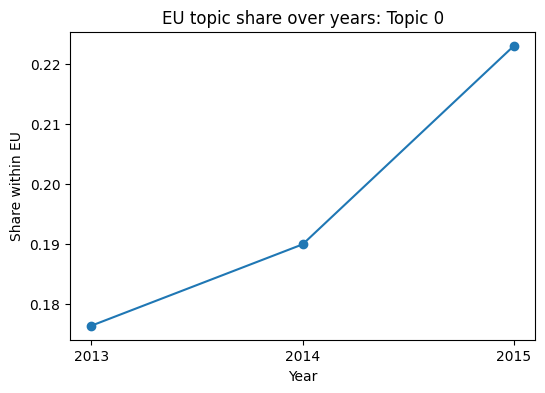

In [47]:
import matplotlib.pyplot as plt

topic_to_plot = valid_topic_ids[0]  # choose one important topic
tmp = eu_year[eu_year["topic"] == topic_to_plot].sort_values("year")

plt.figure(figsize=(6,4))
plt.plot(tmp["year"], tmp["share"], marker="o")
plt.title(f"EU topic share over years: {topic_name(topic_to_plot)}")
plt.xlabel("Year")
plt.ylabel("Share within EU")
plt.xticks(rotation=0)
plt.show()


### Country profiles (top topics per country)

In [48]:
country_topic = (
    df[(df["is_eu"]) & (df["topic"] != -1)]
    .groupby(["year","country","topic"]).size().reset_index(name="n")
)
country_topic["share"] = country_topic["n"] / country_topic.groupby(["year","country"])["n"].transform("sum")
country_topic["topic_name"] = country_topic["topic"].apply(topic_name)

top5 = (country_topic.sort_values(["year","country","share"], ascending=[True, True, False])
        .groupby(["year","country"]).head(5))
top5.head(20)


,year,country,topic,n,share,topic_name
0,2013,Austria,0,3,0.142857,Topic 0
1,2013,Austria,1,2,0.095238,Topic 1
10,2013,Austria,22,2,0.095238,Topic 22
2,2013,Austria,2,1,0.047619,Topic 2
3,2013,Austria,4,1,0.047619,Topic 4
17,2013,Belgium,0,4,0.153846,Topic 0
20,2013,Belgium,3,2,0.076923,Topic 3
27,2013,Belgium,22,2,0.076923,Topic 22
31,2013,Belgium,44,2,0.076923,Topic 44
18,2013,Belgium,1,1,0.038462,Topic 1


### Section analysis (Executive Summary vs Section 1…)

In [49]:
sec_topic = (
    df[(df["topic"] != -1)]
    .groupby(["section","topic"]).size().reset_index(name="n")
)
sec_topic["share_in_section"] = sec_topic["n"] / sec_topic.groupby("section")["n"].transform("sum")
sec_topic["topic_name"] = sec_topic["topic"].apply(topic_name)

sec_topic.sort_values(["section","share_in_section"], ascending=[True, False]).groupby("section").head(5)


,section,topic,n,share_in_section,topic_name
14,EXECUTIVE SUMMARY,45,82,0.147217,Topic 45
15,EXECUTIVE SUMMARY,53,69,0.123878,Topic 53
21,EXECUTIVE SUMMARY,65,56,0.100539,Topic 65
22,EXECUTIVE SUMMARY,70,49,0.087971,Topic 70
26,EXECUTIVE SUMMARY,87,38,0.068223,Topic 87
51,Section 1.,3,615,0.133899,Topic 3
53,Section 1.,5,496,0.107990,Topic 5
54,Section 1.,7,372,0.080993,Topic 7
55,Section 1.,10,327,0.071195,Topic 10
56,Section 1.,11,322,0.070107,Topic 11


### Baseline model (NMF) to compare with BERTopic

In [50]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF

# Use same docs_all you used for BERTopic
vectorizer = TfidfVectorizer(max_df=0.95, min_df=5, stop_words="english")
X = vectorizer.fit_transform(docs_all)

n_topics = min(20, len(valid_topic_ids))  # choose 15-30 usually; keep small for report
nmf = NMF(n_components=n_topics, random_state=42)
W = nmf.fit_transform(X)
H = nmf.components_
vocab = np.array(vectorizer.get_feature_names_out())

def nmf_top_words(H, vocab, topn=15):
    topics = []
    for k in range(H.shape[0]):
        top = vocab[np.argsort(H[k])][::-1][:topn].tolist()
        topics.append(top)
    return topics

nmf_words = nmf_top_words(H, vocab, topn=20)

# Compare coherence/diversity with your existing functions
nmf_div10 = topic_diversity(nmf_words, topk=10)
nmf_coh = coherence_cv([d.split() for d in docs_all], nmf_words)

{"bertopic_coh": metrics["coherence_c_v"], "nmf_coh": nmf_coh,
 "bertopic_div10": metrics["topic_diversity_top10"], "nmf_div10": nmf_div10}


{'bertopic_coh': 0.691497653731012,
 'nmf_coh': 0.6690818455565415,
 'bertopic_div10': 0.5197860962566845,
 'nmf_div10': 0.84}

### Change over time inside EU (2014 → 2015)

In [27]:
eu_df = df[df["is_eu"] & (df["topic"] != -1)].copy()

year_topic = (eu_df.groupby(["year", "topic"]).size().reset_index(name="n"))
year_topic["share_within_year"] = year_topic["n"] / year_topic.groupby("year")["n"].transform("sum")

pivot = year_topic.pivot_table(index="topic", columns="year", values="share_within_year", fill_value=0.0)
if len(pivot.columns) >= 2:
    years = sorted(pivot.columns.tolist())
    pivot["delta"] = pivot[years[-1]] - pivot[years[0]]
    out = pivot.sort_values("delta", ascending=False).head(15).copy()
    out["top_words"] = out.index.map(lambda t: ", ".join(get_topic_words(topic_model, int(t), 8)))
    out.reset_index()
else:
    print("Need both years present to compute change.")


### Zero-shot labels on EU chunks (sample)

In [28]:
from transformers import pipeline

zshot = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")

LABELS = [
    "corruption",
    "judicial independence",
    "police abuse",
    "prison conditions",
    "freedom of expression",
    "freedom of assembly",
    "religious freedom",
    "refugees and asylum",
    "human trafficking",
    "anti-Semitism",
    "LGBTQ+ rights",
    "women's rights",
    "labor rights"
]

zs = eu_df.sample(min(400, len(eu_df)), random_state=7).copy()
res = zshot(zs["text"].tolist(), candidate_labels=LABELS, multi_label=True)

top3 = []
for r in res:
    pairs = sorted(zip(r["labels"], r["scores"]), key=lambda x: x[1], reverse=True)[:3]
    top3.append([p[0] for p in pairs])

zs["top3_labels"] = top3
labels_by_topic = (zs[["topic","top3_labels"]].explode("top3_labels")
                   .groupby(["topic","top3_labels"]).size()
                   .reset_index(name="count")
                   .sort_values(["topic","count"], ascending=[True, False]))
labels_by_topic.head(20)


Device set to use mps:0


KeyboardInterrupt: 